# Практическая задача (36 баллов)

В этой задаче мы поработаем с разреженными системами, в том числе научимся быстро пересчитывать решение при изменениях ранга 1 в матрице левой части.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Расчёт напряжений в системе резисторов

При конструировании сверхбольших интегральных схем (СБИС, very large scale integration, VLSI) одной из базовых задачей является расчёт напряжений в электрических схемах довольно внушительных размеров. Мы рассмотрим модельный пример: сетку $m \times n$ с резисторами сопротивления $R$.

![Сетка из резисторов](resistors.svg)

Потенциалы в узлах сетки обозначим $\varphi_{ij}$, это и будут наши неизвестные. Давайте также считать, что к противоположным углам сетки ($(1,1)$ и $(m,n)$) приложена разность потенциалов $U$. Соответственно, в левый верхний угол втекает (неизвестный) ток $I$, и такой же ток вытекает из правого нижнего угла.

Для решения системы нам будет достаточно закона Ома и первого закона Кирхгофа. Именно, для каждого резистора легко выразить текущий через него ток. Например, для горизонтального резистора между узлами $(i,j)$ и $(i,j+1)$ ток равен $I_{i,j} = (\varphi_{ij} - \varphi_{i,j+1})/R$. Далее применяем первый закон Кирхгофа для каждого узла $(i,j)$, то есть приравниваем сумму втекающих токов к сумме вытекающих. Для внутреннего узла получим такое равенство:
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0.\tag{1}
$$
На границе, например, верхней (то есть $i = 1$), будет отсутствовать член $\varphi_{i-1,j}-\varphi_{i, j}$, а в углу, например, $(1,n)$, будет дополнительно отсутствовать член $\varphi_{i,j}-\varphi_{i, j+1}$. В углах $(1,1)$ и $(m, n)$, однако, ситуация особая: в первом есть дополнительный втекающий неизвестный ток $I$, а во втором этот же ток вытекает.
В результате получим систему на $\varphi_{i,j}$ и $I$:
$$
\left[ \begin{array}{ccccc|c}
   &&   && &  R \\
   &&   && &  0 \\
   && A && &  \vdots  \\
   &&   && &  0 \\
   &&   && & -R \\
   \hline
1 & 0 & \dots &  0 & -1 & 0
\end{array}
\right]
\begin{bmatrix}
\varphi_{11} \\
\vdots       \\
\vdots       \\
\vdots       \\
\varphi_{mn}  \\
I
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\vdots       \\
\vdots       \\
\vdots       \\
0  \\
U
\end{bmatrix}
$$
Последнее уравнение есть $\varphi_{11}-\varphi_{mn} = U$.

Разберёмся с видом матрицы $A$. Она имеет размеры $mn \times mn$ и индексируется двумя парами индексов $ij$ и $i'j'$. Перепишем уравнение (2) в виде 
$$
(\varphi_{i,j-1} - 2\varphi_{i,j} + \varphi_{i,j+1}) + (\varphi_{i-1,j} - 2\varphi_{i,j} + \varphi_{i+1,j}) = 0.\tag{2}
$$
Если переписать столбец $\varphi$ с элементами $\varphi_{ij}$ в матрицу $\Phi\in\mathbb{R}^{m \times n}$ естественным образом (то есть так, чтобы $\mathrm{vec}(\Phi) = \varphi$), то ясно, что первое слагаемое в (2) действует на столбцы матрицы $\Phi$, а второе &mdash; на строки. То есть $A \varphi  = \mathrm{vec}(\Phi A_n) + \mathrm{vec}(A_m \Phi)$, где $A_n \in \mathbb{R}^{n \times n}$ и $A_m \in \mathbb{R}^{m \times m}$ имеют вид
$$
\begin{bmatrix}
-1 & 1 & &  \\
1 & -2 & 1 & \\
  &   & \ddots &  \\
  &     &    1 & -1
 \end{bmatrix}.
$$
По уже известной нам формуле для $\mathrm{vec}(\cdot)$ получается, что $A = I_n \otimes A_m + A_n \otimes I_m$. Операция в правой части ещё называется *Кронекеровой суммой* матриц $A_m$ и $A_n$ и обозначается $A_m \oplus A_n$ (можете проверить, что такая "сумма" не имеет такого интуитивного свойство суммы, как коммутативность, т.е. в общем случае $A_m \oplus A_n \neq A_n \oplus A_m$).

**Обратите внимание**, что система получилась линейно зависимой: если сложить все строки, кроме последней, получится нулевая строка (физически это отвечает тому, что все потенциалы можно сдвинуть на одинаковую константу).
Поэтому мы удалим предпоследнюю строку (не потеряв никакой информации, ведь она равнялась минус сумме остальных), а вместо неё добавим условие $\varphi_{mn} = 0$, таким образом фиксируя один из потенциалов, чтобы уничтожить неопределённость. **Обозначим получившуюся $(mn+1)\times(mn+1)$ матрицу $B$.**

## 1. Разреженное LU-разложение (16 баллов)

a. (**9 баллов**) Сформируйте разреженную матрицу решаемой системы в CSC формате. Для получения матриц $A_m, A_n$ используйте `scipy.sparse.spdiags`, а для сбора $B$ по $A_m, A_n$ используйте `scipy.sparse.kron` (а также другие операции). Обратите внимание, что в этом задании нельзя собирать $A_m, A_n$ или $B$ с использованием операций с плотными матрицами.

In [47]:
from scipy import sparse as sp

def make_A_k(k):
    A = sp.diags([1, -2, 1], [-1, 0, 1], shape=(k, k))
    A = sp.csc_matrix(A)
    A[0, 0] = -1
    A[k - 1, k - 1] = -1
    
    return A

def make_A(m, n):
    "Returns sparse mn x mn matrix A"    
    A_n = make_A_k(n)
    A_m = make_A_k(m)
    # видимо, kronsum использовать запретили :с
    return sp.kron(sp.eye(n), A_m, format='csc') + sp.kron(A_n, sp.eye(m), format='csc') 
    
def make_mat(m, n, R):
    "Returns sparse (mn + 1) x (mn + 1) matrix B of the system in CSC format"
    A = make_A(m, n)
    A[-1, -1] = 1  # уравнение на phi_mn = 0
    A[-1, -2] = 0
    last_col = np.zeros(m*n)
    last_col[0] = R
    B = sp.hstack([A, sp.csc_matrix(last_col[:, np.newaxis])])
    last_row = np.zeros(m*n + 1)
    last_row[0] = 1
    last_row[-2] = -1
    B = sp.vstack([B, sp.csc_matrix(last_row)])
    return sp.csc_matrix(B)

b. (**7 баллов**) Заполните класс `Solver`, который при инициализации выполнит разреженное LU-разложение с помощью библиотеки `scipy.sparse.linalg` и функции `scipy.sparse.linalg.splu`, а затем будет уметь решать систему для заданной правой части.

In [51]:
import scipy.sparse.linalg

class Solver:
    def __init__(self, m, n, R):
        self.splu_obj = sp.linalg.splu(make_mat(m, n, R))
        self.grid_shape = (m, n)
    
    def solve(self, right):
        "Solves the system for given right part"
        # LUx = b, UX = y -> Ly = b
        #y = scipy.sparse.linalg.spsolve_triangular(self.Low, right)
        #x = scipy.sparse.linalg.spsolve_triangular(self.Up, y)
        return self.splu_obj.solve(right)

    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        m, n = self.grid_shape
        right = np.zeros(m*n+1)
        right[-1] = U
        return self.solve(right)

Решим систему и визуализируем полученное решение, чтобы понять, как текут токи.

In [52]:
def visualize(m, n, R, solution, resistance_coeffs={}):
    plt.axis('off')
    max_current = 0
    lines = []
    for i in range(m):
        for j in range(n - 1):
            resistance = R * resistance_coeffs.get((i, j), 1)
            current = (solution[j * m + i] - solution[(j + 1) * m + i]) / resistance
            max_current = max(max_current, current)
            lines += plt.plot([j, j + 1], [-i, -i], color='blue', lw=current)
    for i in range(m - 1):
        for j in range(n):
            current = (solution[j * m + i] - solution[j * m + i + 1]) / R
            max_current = max(max_current, current)
            lines += plt.plot([j, j], [-i, -i - 1], color='blue', lw=current)
    for l in lines:
        l.set_linewidth(l.get_linewidth() * 4. / max_current)

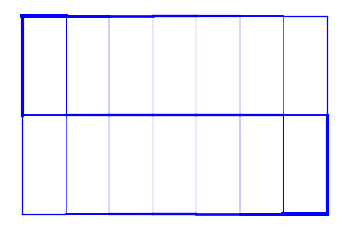

In [53]:
m, n, R = 3, 8, 1.
solver = Solver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))

Проверьте, что ваш солвер работает для больших систем.

In [54]:
m, n, R = 500, 500, 1.
solver = Solver(m, n, R)
_ = solver.solve_voltage(220.)

## 2. Обновления ранга 1 (20 баллов)

Представим теперь, что в процессе работы резисторы в нашей системе могут менять своё сопротивление, например, при перегреве проводник может потерять проводимость ($R_{i,j} = \infty$) или, напротив, может произойти короткое замыкание ($R_{i,j} = 0$). При таких локальных изменениях нет нужды строить и решать заново всю нашу линейную систему.

a. (**8 баллов**) Будем считать для простоты, что сопротивление меняется только в горизонтальных резисторах, не инцидентных узлам $(1,1)$ и $(m, n)$. Пусть сопротивление между узлами $(i,j)$ и $(i,j+1)$ изменилось с $R$ на $R'$. Пользуясь формулой (1), выпишите новую матрицу $B'$ в виде $B' = B + uv^\top$.


(можно написать решение в строчке ниже или на листке в теоретической части)

Далее воспользуемся формулой Шермана-Моррисона для обращения матрицы $B + uv^\top$.

b. (**12 баллов**) Напишите класс `UpdatableSolver`, использующий `Solver`, но вдобавок умеющий умножать сопротивление в заданном "горизонтальном" резисторе между $(i,j)$ и $(i,j+1)$ на заданное число.

In [ ]:
class UpdatableSolver(Solver):
    def __init__(self, m, n, R):
        super().__init__()
        
    def solve(self, right):
        "Solves the updated system for given right part"
        # YOUR CODE GOES HERE
        raise NotImplementedError
    
    def update(self, i, j, coeff):
        """
            Updates the system so that the resistance between (i,j) and (i,j+1)
            is mutiplied by coeff.
        """
        # YOUR CODE GOES HERE
        raise NotImplementedError
    
    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        # YOUR CODE GOES HERE
        raise NotImplementedError

Поэкспериментируем с изменением проводимости отдельных участков. Попробуем сильно увеличить сопротивление сначала одного, затем другого резистора в одном вертикальном ряду. 

In [ ]:
m, n, R = 3, 8, 1.
solver = UpdatableSolver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))
plt.figure()
coeff = 1000
resistance_coeffs = {(1,3): coeff}
solver.update(1, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)
plt.figure()
resistance_coeffs[(2,3)] = coeff
solver.update(2, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)

Также проверим, что новый солвер работает для больших систем.

In [ ]:
m, n, R = 300, 300, 1.
solver = UpdatableSolver(m, n, R)
solver.solve_voltage(220.)
solver.update(10, 20, 100.)
solver.update(20, 30, 100.)
solver.update(30, 40, 100.)
_ = solver.solve_voltage(220.)